# Section 3: Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis), here are some examples:
* How much will this house sell for?
* How many people eill bui this app?
* Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
* Predict the coordinates of a bounding box of an item in an image.
* Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

As you can see, the trend is **how much or many something**, to simplyfi it a regression problem is basically **predicting a number** of some sort, maybe coordinates, prices, etc.

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## Import Section

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.10.1


## Introduction

### What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:

* **Architecture of a regression model**
* **Input shapes and output shapes**
  * X: features/data (inputs)
  * y: labels (outputs)
* **Creating custom data to view and fit**
* **Steps in modelling**
  * Creating a model
  * Compiling a model
    * *Defining a loss function*
    * *Setting up an optimizer*
    * *Creating evaluation metrics*
  * Fitting a model (getting it to find patterns in our data)
* **Evaluating a model**
  * Visualizng the model ("visualize, visualize, visualize")
  * Looking at training curves
  * Compare predictions to ground truth (using our evaluation metrics)
* **Saving a model** (so we can use it later)
* **Loading a model**

Don't worry if none of these make sense now, we're going to go through each.

### Inputs and Outputs of a Neural Network Regression Model

For this example let's say we have a house for sale and we want to build a model to predict how much I should offer if we go to auction:

What do we know:
* Independent Variables or Features:
  * Number of Bathrooms (x4)
  * Number of Bedrooms (x2)
  * Number of Garages (x2)
* Dependant or Target Variables:
  * We now the prices of other houses nearby

**Inputs:** We have to encode the Features to pass them to the model. It can be as many Features as we want, therefore the shape won't necessarily be fixed.
`features = [f1, f2, f3, f4, f5, f6, f7, ..., fn]`

**ML Algorithms:** Often someone already did a model to fix your problem, if not, you can build one

**Outputs:** Based on the Features and the targets from other records, the model gives us the predicted output. Normally in regression models the shape of the output is fixed to 1.
`output = [123456]`

### Typical architecture of a regresison neural network

#### Graphical Representation - Simple Example and Explanation

![Neural Network Architecture](../assets/nn_representation.png)

| Layer(s) | Description                                                | Units/Neurons in the example image |
| -------- | ---------------------------------------------------------- | :--------------------------------: |
| Input    | Where the data goes in                                     | 3
| Hidden   | Learns patterns in data                                    | 4
| Output   | Outputs learned representation or prediction probabilities | 1

#### Complete Explanation

**There are many different ways (actually, there's almost an infinite number of ways) to write neural networks, but the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputting some kind of target number.**


| Hyperparameters          | Typical Value |
| ------------------------ | ------------- |
| Input layer shape        | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s)	       | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape	   | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation	       | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation	       | None, ReLU, logistic/tanh |
| Loss function	           | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer                | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

*Table 1: Typical architecture of a regression network. Source: Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

## Video Activities 

### 42. Creating Sample Regression Data (so we can model it)

* [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

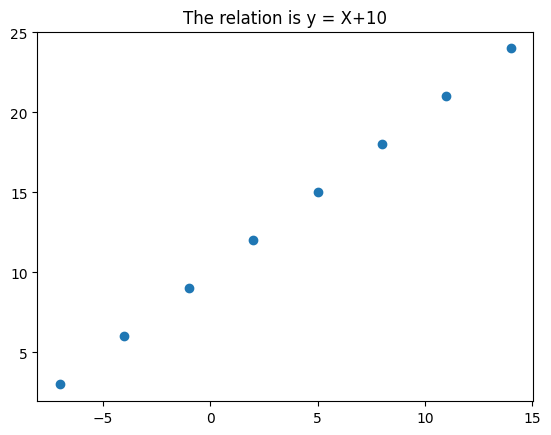

In [3]:
# Creating features
X = np.array(
    [-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0]
)

# Create labels
y = np.array(
    [3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0]
)

# Visualize it
plt.scatter(X,y)
plt.title('The relation is y = X+10')
plt.show()

In [4]:
y == X+10

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [5]:
## Input and Output Shapes - Create a demo tensor for our housing price prediction problem
house_info = tf.constant(
    ['bedroom', 'bathroom', 'garage']
)

house_price = tf.constant(
    [939700]
)

house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700])>)

In [6]:
# In the following case we have 1 input feature to predict 1 output feature, 
# therfore we have shape 0 since the input and output are scalars, either way
# we still have 1 input for 1 output
input_shape = X.shape
output_shape = y.shape

input_shape, output_shape

((8,), (8,))

### 44. The mayor steps in modeling with TensorFlow

In [7]:
# NumPy arrays into tensors
X = tf.cast(tf.constant(X), dtype = tf.float32)
y = tf.cast(tf.constant(y), dtype = tf.float32)

X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [8]:
input_shape = X[0].shape
output_shape = y[0].shape

input_shape, output_shape


(TensorShape([]), TensorShape([]))

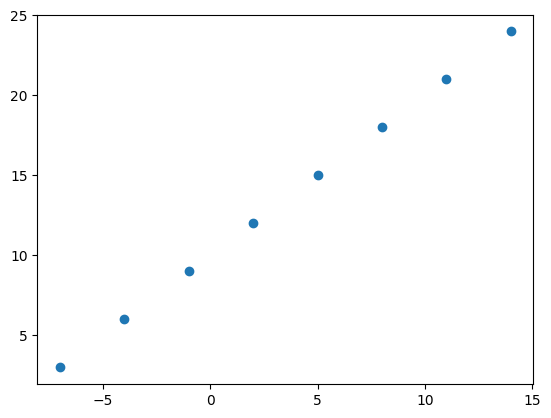

In [9]:
plt.scatter(X, y)

#### **Steps in modelling with TensorFlow**

1. **Create model**
   1. Defines for the Deep Learning Model:
      1. *Input Layer(s)*
      2. *Hidden Layer(s)*
      3. *Output Layer(s)*

2. **Compiling a model**
   1. Defines:
      1. *Loss function*
      2. *Optimizer to improve the patterns*
      3. *Evaluation metrics*
3. **Fitting the model**
   1. Letting the model try to find patterns between X and y (Features and Labels)
   2. Defines:
      1. *Epochs* (How many times the model will go through all of the training samples)
4. Evaluate the model on the test data

**Note:** 

You might see this error

```
ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None
```
This happens because `model.fit()` no longer automatically upscales inputs from shape `(batch_size, )` to `(batch_size, 1)`.

This results in a shape error (remember one of most common errors in deep learning is input and output shapes).

**You can add an extra dimension to your input data by using:** 
* `tf.expand_dims(input_data, axis = -1)`

**The code adds an extra dimension to X on the last axis, turning it ndim=1 to ndim=2 (what the model requires).**


In [17]:
# Random seed
tf.random.set_seed(42)

# Create a model using the Sequential API
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1)
    ]
)

# 2. Compile the model
model.compile(
    loss = tf.keras.losses.mae, # Mean Absolute Error loss = mean(abs(y_true - y_pred), axis = 1)
    optimizer = tf.keras.optimizers.SGD(), # Stochastic gradient descent
    metrics = ['mae'] 
)

# Fit the model 
model.fit(
    tf.expand_dims(X, axis= -1),
    y,
    epochs=5
)

Epoch 1/5


1/1 [==============================] - 0s 274ms/step - loss: 12.8676 - mae: 12.8676
Epoch 2/5
1/1 [==============================] - 0s 5ms/step - loss: 12.7351 - mae: 12.7351
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 12.6026 - mae: 12.6026
Epoch 4/5
1/1 [==============================] - 0s 5ms/step - loss: 12.4701 - mae: 12.4701
Epoch 5/5
1/1 [==============================] - 0s 4ms/step - loss: 12.3376 - mae: 12.3376


In [11]:
# Let's check X and y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [12]:
# Make a prediction using the model
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 81ms/step


array([[1.097427]], dtype=float32)

In [13]:
model.predict([-4.])

1/1 [==============================] - 0s 39ms/step


array([[-0.2520416]], dtype=float32)

In [14]:
y_pred + 8.9057

array([[10.003127]], dtype=float32)

### 45 - 47. Improving a Model

#### 45. Steps in improving a model with TensorFlow - Part 1

We can improve our model by altering the steps we took to create a model

1. **Creating a Model:** We might add layers, increase the hidden units within the hidden layers, change the activation function of each layer
2. **Compiling a Model:** Here we might change the optimization function or perhaps the **learning rate** of the optimization function
3. **Fitting a Model:** Here we might fit a model for more **epochs** (leave it training longer) or on more data (give the model more examples to learn from)

In [26]:
# 1. Creating a Model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1)
    ]
)

# 2. Compile the Model - Optimization Function and Learning Rate
model.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.SGD(), # Stochastic gradient descent
    metrics = ['mae']
)

# 3. Fit the Model - More Epochs and Data
model.fit(
    tf.expand_dims(
        X, 
        axis = -1
    ), 
    y, 
    epochs=100
) # Originally only 5 epochs

Epoch 1/100


1/1 [==============================] - 0s 229ms/step - loss: 9.2168 - mae: 9.2168
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 9.0843 - mae: 9.0843
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 8.9518 - mae: 8.9518
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 8.8193 - mae: 8.8193
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 8.6868 - mae: 8.6868
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 8.5543 - mae: 8.5543
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 8.4218 - mae: 8.4218
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 8.2893 - mae: 8.2893
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 8.1568 - mae: 8.1568
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 8.0243 - mae: 8.0243
Epoch 11/100
1/1 [==============================] - 0s 15ms/step - loss: 7.8918 - mae

In [27]:
print(X)
print(y)

tf.Tensor([-7. -4. -1.  2.  5.  8. 11. 14.], shape=(8,), dtype=float32)
tf.Tensor([ 3.  6.  9. 12. 15. 18. 21. 24.], shape=(8,), dtype=float32)


In [28]:
y_pred = model.predict(
    [17.0]
)
y_pred

1/1 [==============================] - 0s 54ms/step


array([[29.919144]], dtype=float32)

#### 46. Steps in improving a model with TensorFlow - Part 2

In [30]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation = "relu"),
        tf.keras.layers.Dense(100, activation = "relu"),
        tf.keras.layers.Dense(100, activation = "relu"),
        tf.keras.layers.Dense(1)
    ]
)

model.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.SGD(),
    metrics = ['mae']
)

model.fit(
    tf.expand_dims(X, axis = -1),
    y,
    epochs = 100
)

Epoch 1/100


1/1 [==============================] - 0s 427ms/step - loss: 13.5231 - mae: 13.5231
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 13.2116 - mae: 13.2116
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 12.9049 - mae: 12.9049
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 12.5842 - mae: 12.5842
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 12.2341 - mae: 12.2341
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 11.8414 - mae: 11.8414
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 11.3574 - mae: 11.3574
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 10.7981 - mae: 10.7981
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 10.1140 - mae: 10.1140
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 9.2664 - mae: 9.2664
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - lo

In [33]:
print(X)
print(y)

tf.Tensor([-7. -4. -1.  2.  5.  8. 11. 14.], shape=(8,), dtype=float32)
tf.Tensor([ 3.  6.  9. 12. 15. 18. 21. 24.], shape=(8,), dtype=float32)


In [31]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 67ms/step


array([[32.9666]], dtype=float32)

#### 47. Steps in improving a model with TensorFlow - Part 3

In [40]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(50, activation = "relu"),
        tf.keras.layers.Dense(50, activation = "relu"),
        tf.keras.layers.Dense(50, activation = "relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss = tf.keras.losses.mae,
    optimizer = tf.keras.optimizers.Adam(lr=0.01),
    metrics = ['mae']
)

model.fit(
    tf.expand_dims(
        X, 
        axis = -1
    ),
    y,
    epochs = 100
)

Epoch 1/100


1/1 [==============================] - 0s 385ms/step - loss: 15.1564 - mae: 15.1564
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 12.9258 - mae: 12.9258
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 11.3261 - mae: 11.3261
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 9.7606 - mae: 9.7606
Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 8.2609 - mae: 8.2609
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 6.2649 - mae: 6.2649
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 4.0124 - mae: 4.0124
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 4.8940 - mae: 4.8940
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 5.8618 - mae: 5.8618
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 5.9268 - mae: 5.9268
Epoch 11/100
1/1 [==============================] - 0s 7ms/step - loss: 5.430

In [41]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 67ms/step


array([[27.122803]], dtype=float32)

### 48 - 55. Evaluating a TensorFlow Model

In practice, a typical workflow we'll have to go through when building neural networks is:

```
Build mode -> Fit -> Evaluate -> tweak model -> Build mode -> Fit -> Evaluate -> tweak model -> Build mode -> Fit -> Evaluate -> tweak model -> ...
```

#### 48. "Visualize, Visualize, Visualize"

It's a good idea to visualize:
* **Data** - What data are we working with? What does it look like?
* **Model** - What does our model look like?
* **Training of a Model** - How does a model perform while it learns?
* **Predictions** - How do the predictions of a model line up against the groudn truth (original labels)?

In [55]:
# Make bigger dataset
X = tf.range(-100, 100, 4)
y = (X + 10)

X, y

(<tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
         -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
         -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
          32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
          76,   80,   84,   88,   92,   96])>,
 <tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
        -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
         14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
         66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106])>)

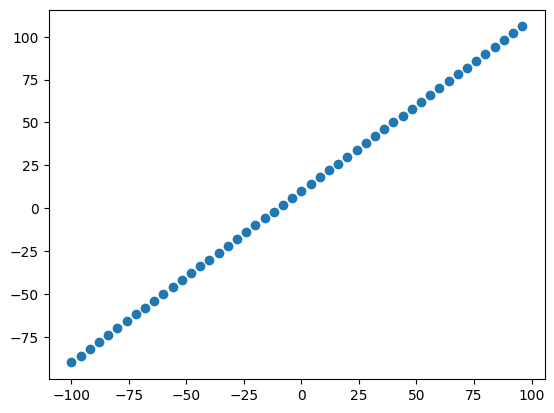

In [56]:
# Visualize the data
plt.scatter(X, y)

#### 49. The Three Datasets

In [60]:
# Training | Validation(?) | Test
X_train, X_test, y_train, y_test = train_test_split(
    X.numpy(), 
    y.numpy(),
    test_size = 0.2,
    random_state = 42
)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

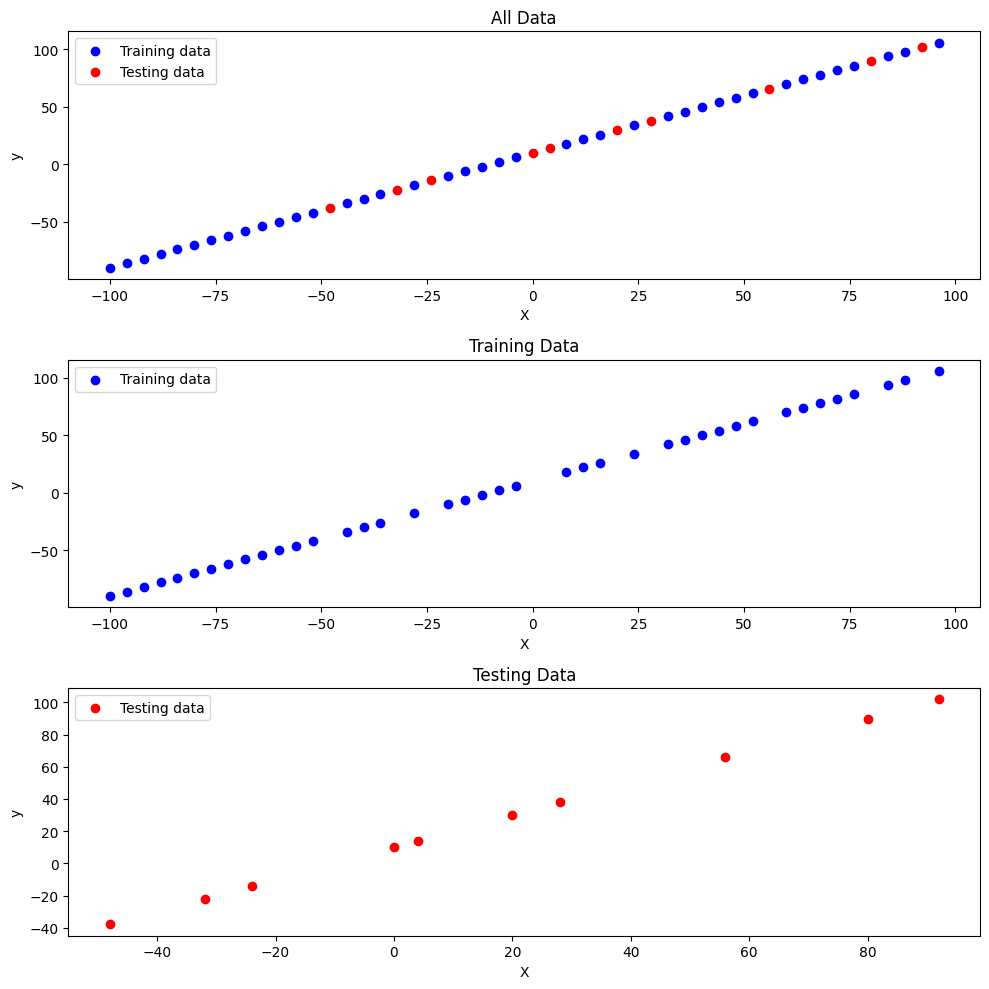

In [66]:
# Visualize splitted data
fig, axes = plt.subplots(
    figsize = (10, 10),
    nrows=3,
    ncols  = 1
)

# Plot training data
axes[0].scatter(X_train, y_train, color='blue', label='Training data')
axes[0].scatter(X_test, y_test, color='red', label='Testing data')
axes[0].set_title('All Data')
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].legend()

# Plot training data
axes[1].scatter(X_train, y_train, color='blue', label='Training data')
axes[1].set_title('Training Data')
axes[1].set_xlabel('X')
axes[1].set_ylabel('y')
axes[1].legend()

# Plot testing data
axes[2].scatter(X_test, y_test, color='red', label='Testing data')
axes[2].set_title('Testing Data')
axes[2].set_xlabel('X')
axes[2].set_ylabel('y')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### 50. Getting a model summary

#### 51. Visualizing a Model's Layer

#### 52. Visualizing a Model's Predictions

#### 53. Common Regression Evaluation Metrics

#### 54. Mean Absolute Error

#### 55. Mean Square Error

### 56 - 57. Setting up Modelling Experiments

#### 56. Start with a Simple Model

#### 57. Increasing Complexity

### 58. Comparing and tracking your TensorFlow modelling experiments

### 59. How to save a TensorFlow model

### 60. How to load and use a saved TensorFlow model

### 62 - 64. Putting together what we've learned

#### 62. Preparing a Dataset

#### 63. Building a Regression Model

#### 64. Improving our Regression Model

### 65 - 67. Preprocessing data with Feature Scaling

#### 65. What is Feature Scaling?

#### 66. Normalizing our Data

#### 67. Fitting a Model on Scaled Data